In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OrdinalEncoder


In [3]:
# Load and preprocess the train data
df = pd.read_csv("train.csv")
df = df.drop('Id', axis=1)

In [4]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [5]:
# Fill missing values for categorical features
df['PoolQC'] = df['PoolQC'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['GarageCond'] = df['GarageCond'].fillna('None')
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

<Figure size 2000x1500 with 0 Axes>

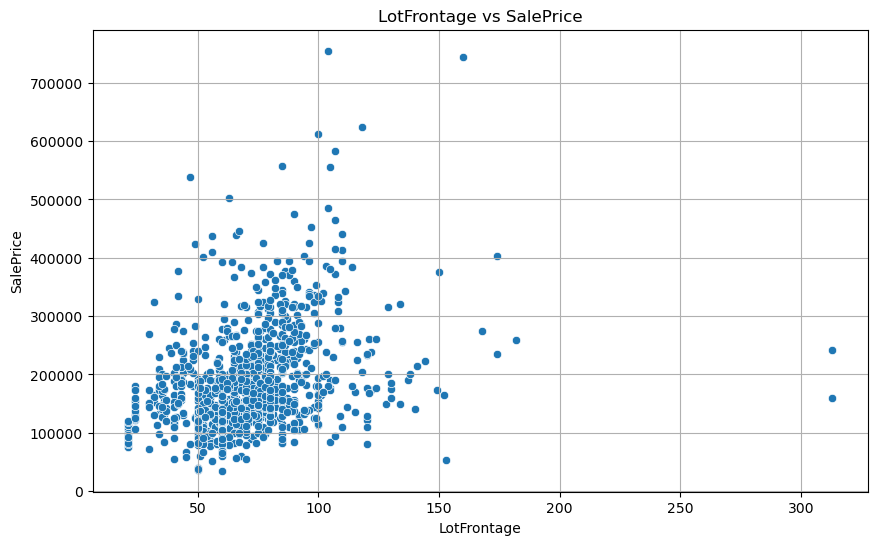

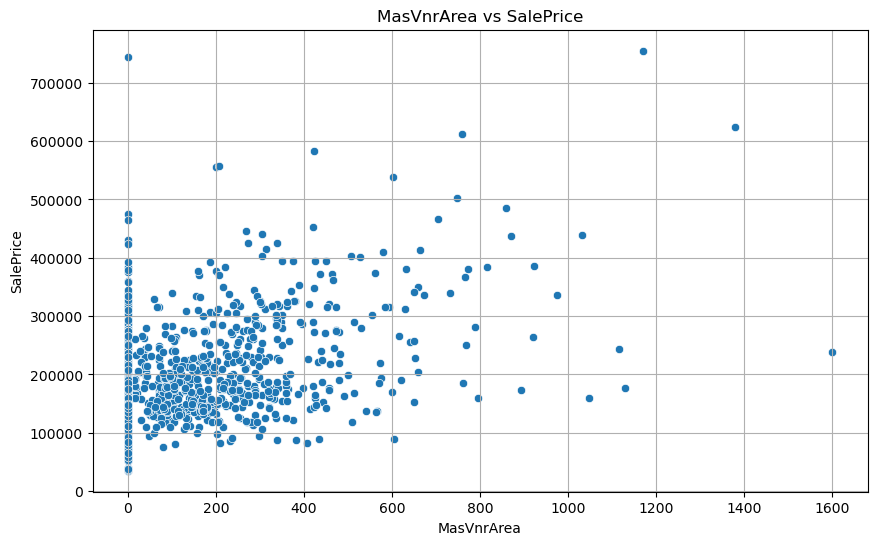

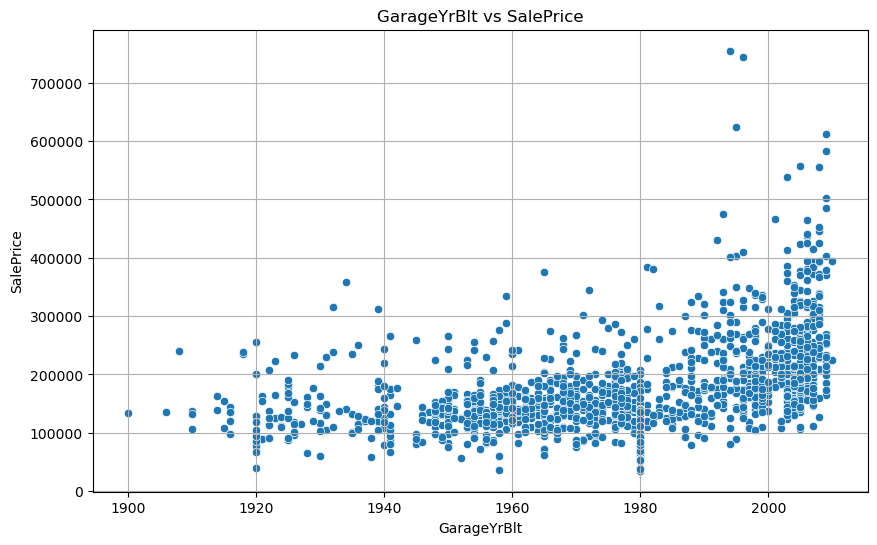

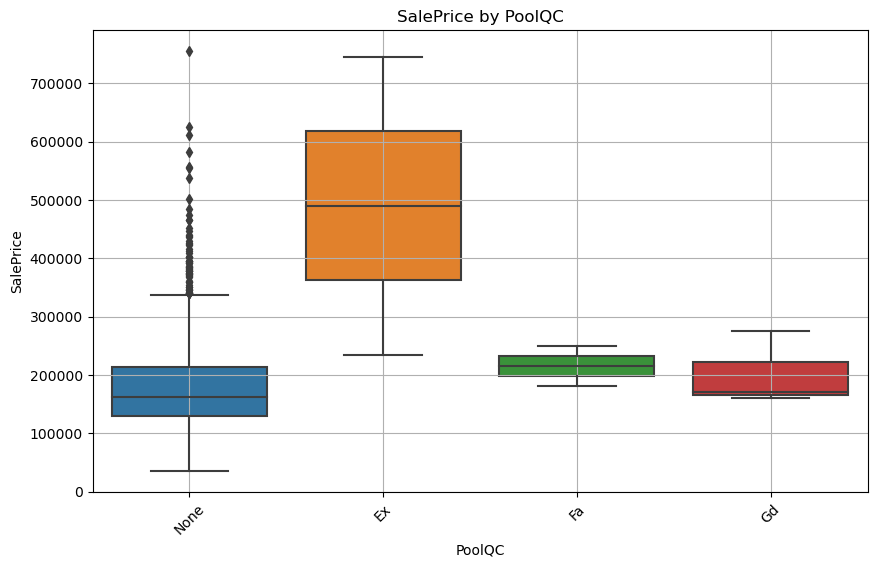

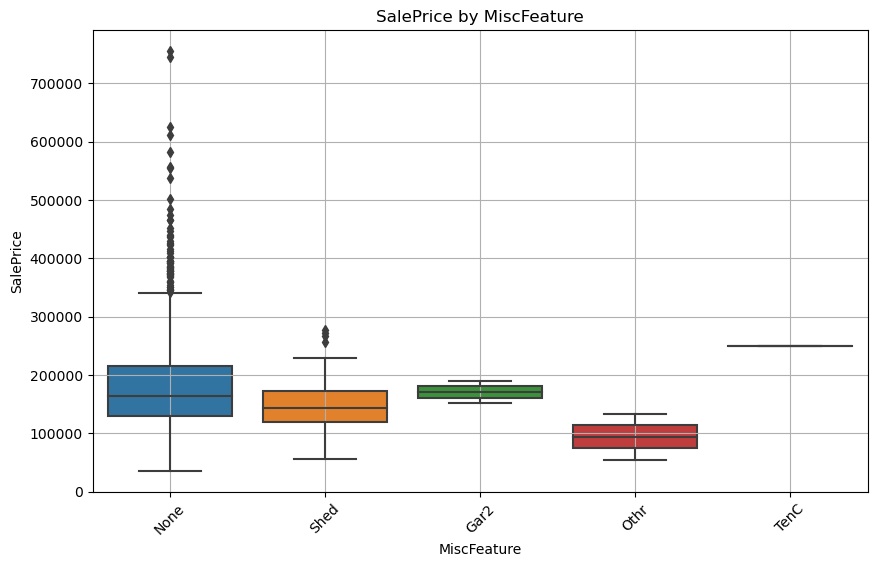

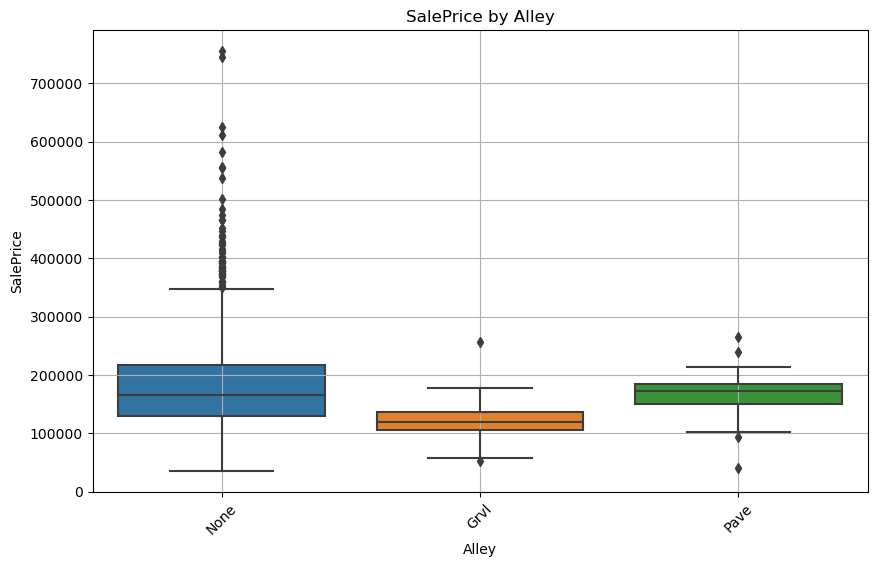

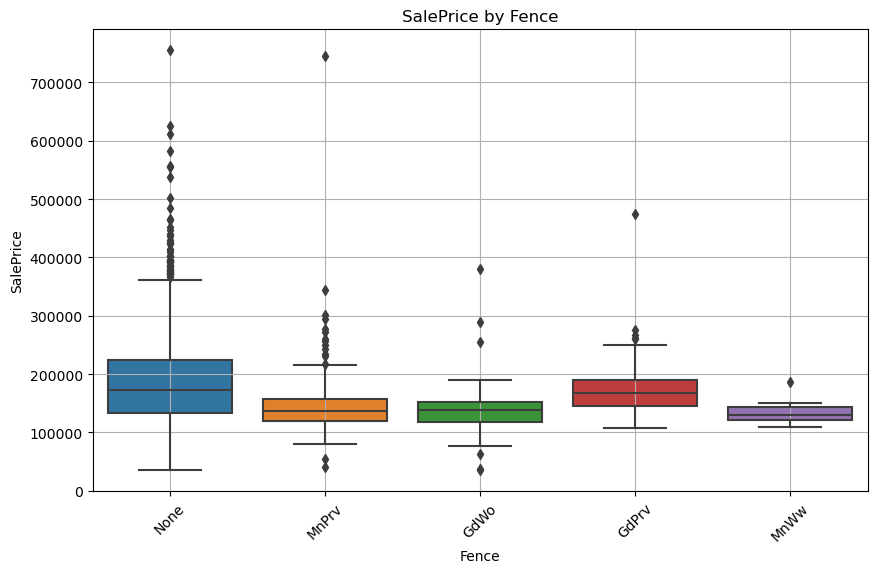

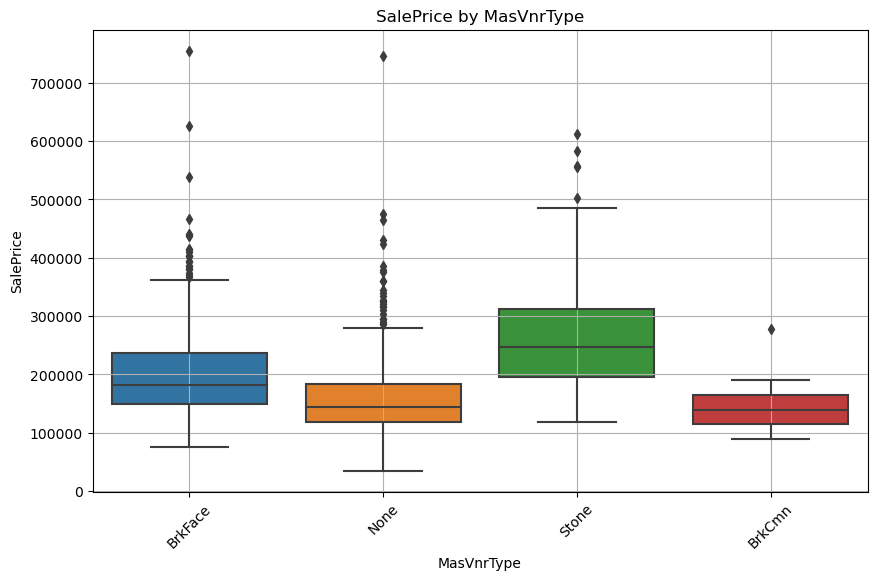

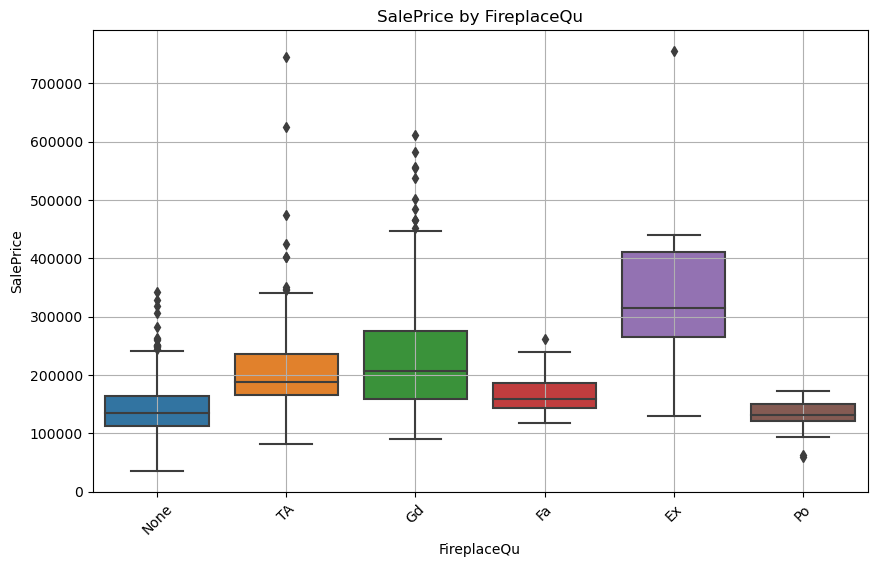

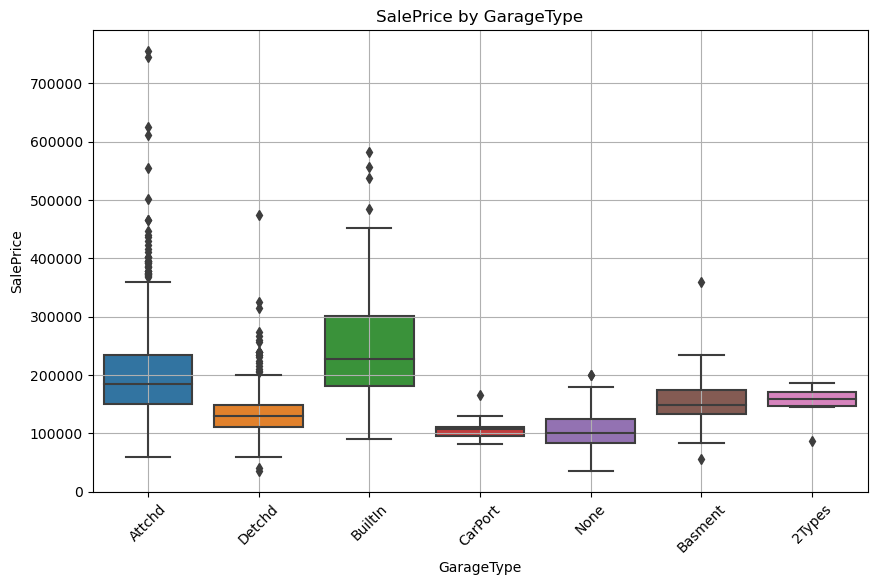

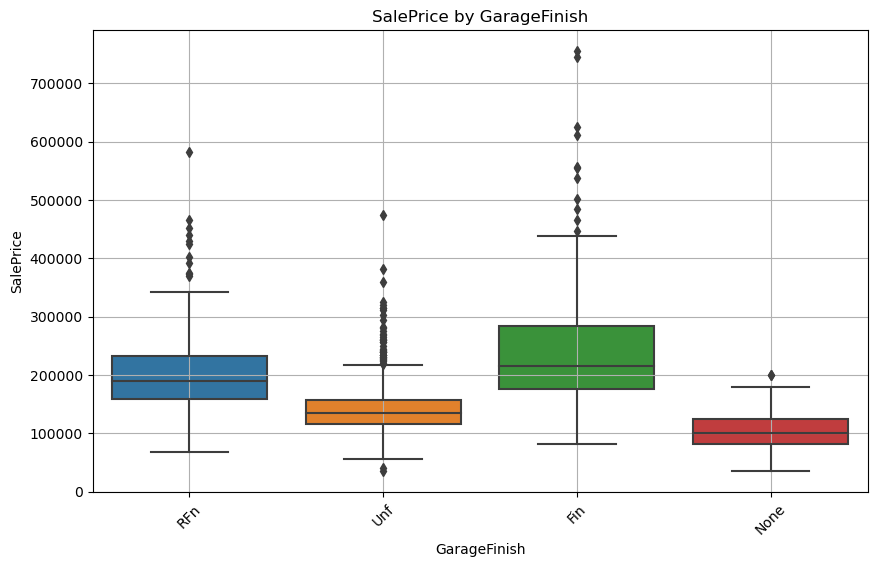

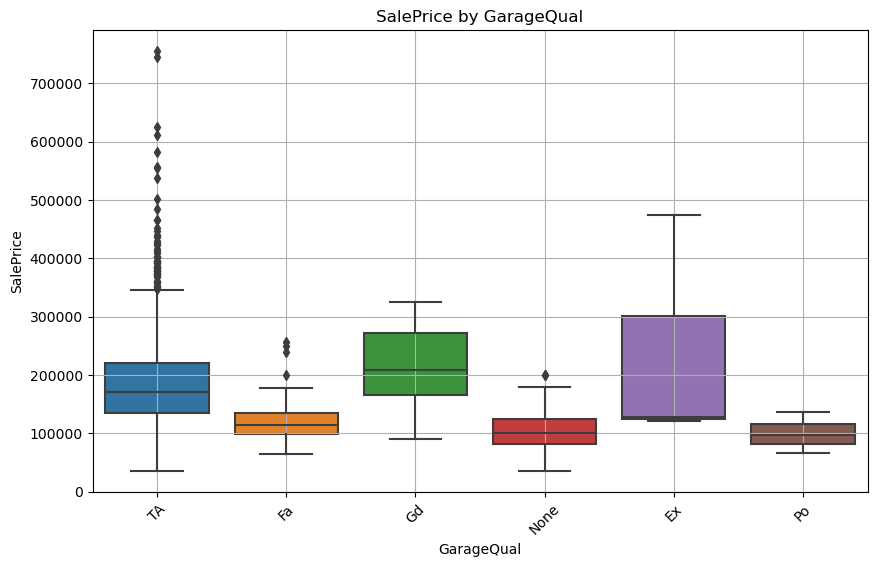

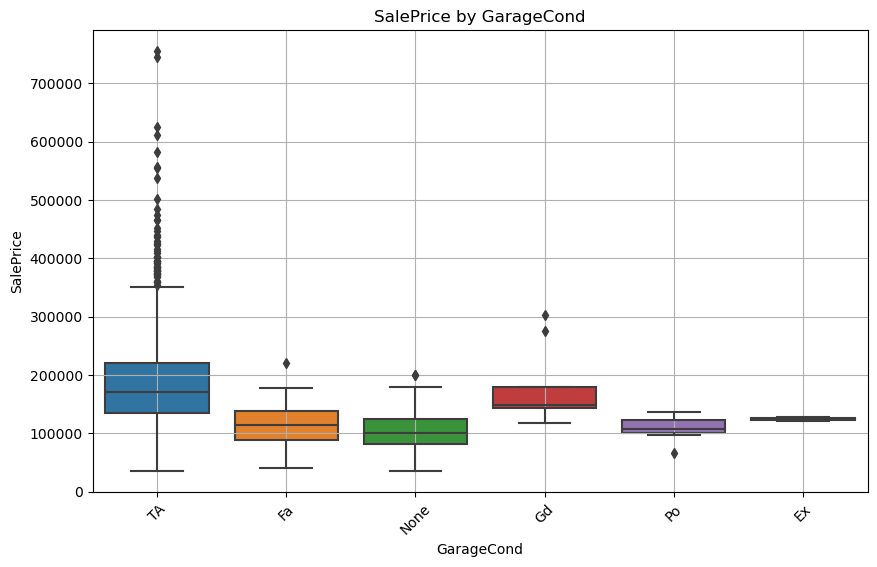

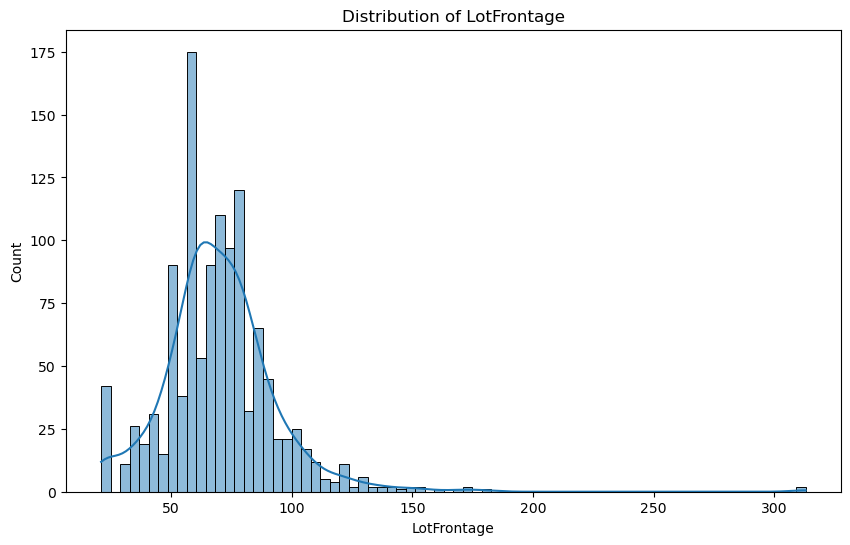

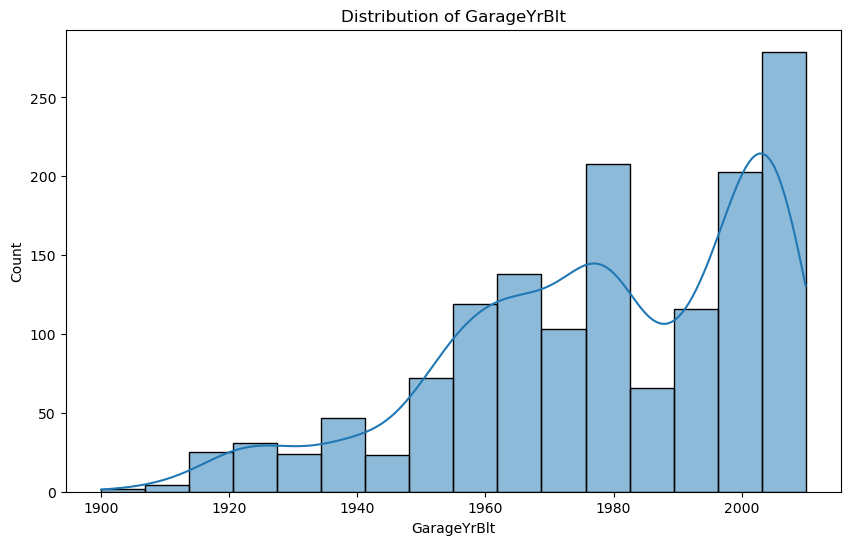

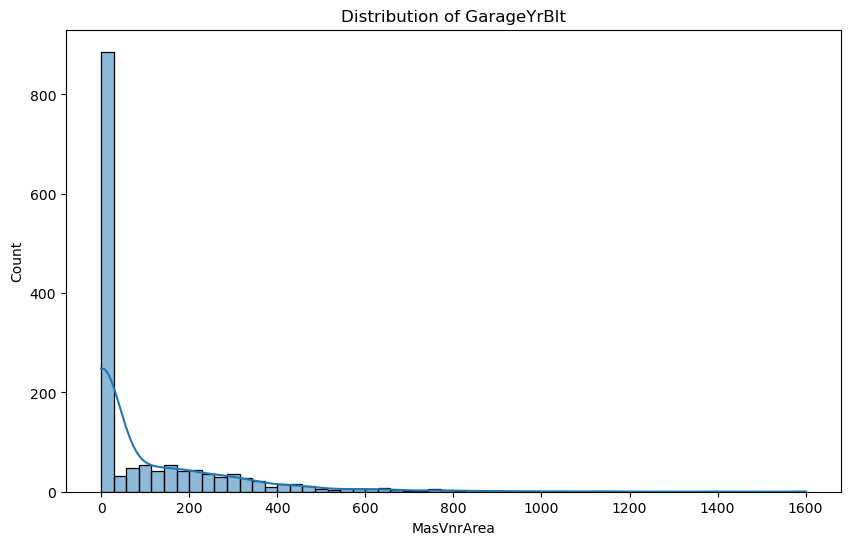

In [6]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Plot numerical features
numerical_features = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'{feature} vs SalePrice')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.grid(True)
    plt.show()

# Plot categorical features
categorical_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature], y=df['SalePrice'])
    plt.title(f'SalePrice by {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Plot the distribution of LotFrontage
plt.figure(figsize=(10, 6))
sns.histplot(df['LotFrontage'].dropna(), kde=True)
plt.title('Distribution of LotFrontage')
plt.show()

# Plot the distribution of GarageYrBlt
plt.figure(figsize=(10, 6))
sns.histplot(df['GarageYrBlt'].dropna(), kde=True)
plt.title('Distribution of GarageYrBlt')
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(df['MasVnrArea'].dropna(), kde=True)
plt.title('Distribution of GarageYrBlt')
plt.show()


In [7]:
# Log transform skewed features (example: SalePrice, TotalBsmtSF)
skewed_features = ['SalePrice', 'TotalBsmtSF', 'GrLivArea']
df[skewed_features] = df[skewed_features].apply(np.log1p)

# Create the "HouseAge" feature
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
# Create the "RemodelAge" feature
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
# Create the "GarageAge" feature
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
# Create the "TotalBathrooms" feature
df['TotalBathrooms'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']
# Create the "TotalPorchArea" feature
df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# Create the "TotalSF" feature
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']

df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
# Example: Interaction between house age and total square footage
df['Age_SF_Interaction'] = df['HouseAge'] * df['TotalSF']



In [8]:


# Polynomial Features for key variables (GrLivArea, OverallQual)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[['GrLivArea', 'OverallQual']])
poly_feature_names = poly.get_feature_names_out(['GrLivArea', 'OverallQual'])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

In [9]:
# Concatenate polynomial features with the original dataframe
df = pd.concat([df, df_poly], axis=1)

missing_values = df.isnull().sum()
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("None",inplace=True)
print(df.head())
df.isnull().sum()

# Binary Encoding
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})


   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave  None      Reg   
1          20       RL         80.0     9600   Pave  None      Reg   
2          60       RL         68.0    11250   Pave  None      IR1   
3          70       RL         60.0     9550   Pave  None      IR1   
4          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig  ... RemodelAge GarageAge TotalBathrooms  \
0         Lvl    AllPub    Inside  ...          5       5.0              4   
1         Lvl    AllPub       FR2  ...         31      31.0              3   
2         Lvl    AllPub    Inside  ...          6       7.0              4   
3         Lvl    AllPub    Corner  ...         36       8.0              2   
4         Lvl    AllPub       FR2  ...          8       8.0              4   

  TotalPorchArea      TotalSF IsRemodeled  Age_SF_Interaction  GrLivArea  \
0             61  1716.753438     

In [10]:

# Ordinal Encoding
ordinal_features = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Typ', 'Min2', 'Min1', 'Mod', 'Maj2', 'Maj1','Sev'],
    'FireplaceQu': ['None','Po', 'Fa', 'TA', 'Gd', 'Ex']
}

ordinal_encoder = OrdinalEncoder(categories=[
    ordinal_features['ExterQual'],
    ordinal_features['ExterCond'],
    ordinal_features['HeatingQC'],
    ordinal_features['KitchenQual'],
    ordinal_features['Functional'],
    ordinal_features['FireplaceQu']
])

df[['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional','FireplaceQu']] = ordinal_encoder.fit_transform(
    df[['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional','FireplaceQu']]
)

# One-Hot Encoding
nominal_features = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'Electrical', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
    'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
]


In [11]:
df = pd.get_dummies(df, columns=nominal_features, drop_first=True)

# Split features and target
x = df.drop('SalePrice', axis=1)
y = df['SalePrice']
df_train=df
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [12]:
# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [13]:


from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid for XGBRegressor
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [1000, 2000, 3000, 5000],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.0001, 0.001],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight':[1,5,15,200],
    'lambda':[1,2,3]
}

# Initialize and perform Randomized Search for XGBoost
xgb = XGBRegressor(random_state=42)
xgb_random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
xgb_random_search.fit(x_train, y_train)
print(f"Best Parameters for XGBoost: {xgb_random_search.best_params_}")

# Best model after Randomized Search
best_xgb_model = xgb_random_search.best_estimator_

# Predictions on test data
y_pred_xgb = best_xgb_model.predict(x_test)

# Evaluate model performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost R-squared: {r2_xgb}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for XGBoost: {'subsample': 0.8, 'reg_alpha': 0.0001, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 0.7}
XGBoost MSE: 0.01728470344784984
XGBoost RMSE: 0.13147130275406052
XGBoost MAE: 0.08848984035575663
XGBoost R-squared: 0.9073757468488872


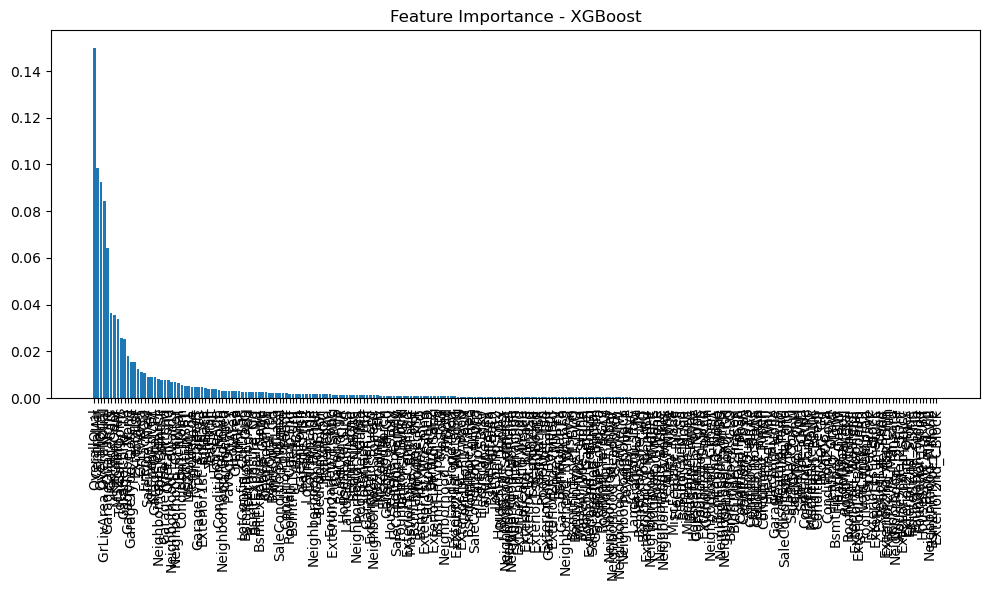

['OverallQual' 'CentralAir' 'OverallQual' 'GrLivArea OverallQual'
 'GarageQual_None' 'GarageCars' 'KitchenQual' 'MSZoning_RM'
 'TotalBathrooms' 'GarageCond_TA' 'GarageType_None' 'GarageType_Detchd'
 'ExterQual' 'TotalSF' 'GrLivArea' 'FireplaceQu' 'SaleType_New'
 'KitchenAbvGr' 'GarageQual_TA' 'Neighborhood_ClearCr' 'TotalBsmtSF'
 'GarageType_Attchd' 'OverallCond' 'Neighborhood_Edwards'
 'Neighborhood_Crawfor' 'Functional' 'Condition1_Norm' 'BsmtFinSF1'
 'MSZoning_RL' 'RemodelAge' 'Fireplaces' 'GarageType_CarPort'
 'Exterior1st_BrkFace' 'FullBath' '1stFlrSF' 'YearBuilt' 'HouseAge'
 'Condition2_Norm' 'Neighborhood_OldTown' 'GarageArea' 'PavedDrive_Y'
 'LotArea' 'GrLivArea' '2ndFlrSF' 'LotConfig_CulDSac' 'BsmtFinType1_GLQ'
 'YearRemodAdd' 'BsmtExposure_Gd' 'BsmtExposure_No' 'BsmtExposure_None'
 'Fence_GdWo' 'OpenPorchSF' 'BsmtQual_TA' 'BsmtQual_Gd' 'MSSubClass'
 'SaleCondition_Normal' 'PoolArea' 'Condition1_Feedr' 'RoofMatl_CompShg'
 'BsmtFinType1_Unf' 'HalfBath' 'ScreenPorch' 'GarageYrBl

In [14]:

# Plot feature importances
feature_importances_xgb = best_xgb_model.feature_importances_
sorted_indices_xgb = np.argsort(feature_importances_xgb)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance - XGBoost')
plt.bar(range(x.shape[1]), feature_importances_xgb[sorted_indices_xgb], align='center')
plt.xticks(range(x.shape[1]), np.array(x.columns)[sorted_indices_xgb], rotation=90)
plt.tight_layout()
plt.show()


print( np.array(x.columns)[sorted_indices_xgb])

In [15]:
test_data=pd.read_csv("test.csv")
test_data.info()

df.info()
data1=pd.read_csv("train.csv")
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [16]:


df=test_data
# Fill missing values for categorical features
df['PoolQC'] = df['PoolQC'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['GarageCond'] = df['GarageCond'].fillna('None')
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].median())
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(df['BsmtFullBath'].median())
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].median())
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].median())
df['GarageCars'] = df['GarageCars'].fillna(df['GarageCars'].median())
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].median())
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].median())
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].median())

In [17]:


# Log transform skewed features (example: SalePrice, TotalBsmtSF)
skewed_features = ['TotalBsmtSF', 'GrLivArea']
df[skewed_features] = df[skewed_features].apply(np.log1p)

# Create the "HouseAge" feature
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
# Create the "RemodelAge" feature
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
# Create the "GarageAge" feature
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']
# Create the "TotalBathrooms" feature
df['TotalBathrooms'] = df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] + df['BsmtHalfBath']
# Create the "TotalPorchArea" feature
df['TotalPorchArea'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# Create the "TotalSF" feature
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']

df['IsRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
# Example: Interaction between house age and total square footage
df['Age_SF_Interaction'] = df['HouseAge'] * df['TotalSF']


In [18]:

# Polynomial Features for key variables (GrLivArea, OverallQual)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[['GrLivArea', 'OverallQual']])
poly_feature_names = poly.get_feature_names_out(['GrLivArea', 'OverallQual'])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)


In [19]:

# Concatenate polynomial features with the original dataframe
df = pd.concat([df, df_poly], axis=1)
df['TotalBathrooms'] = df['TotalBathrooms'].fillna(df['TotalBathrooms'].median())
df['TotalSF'] = df['TotalSF'].fillna(df['TotalSF'].median())
df['Age_SF_Interaction'] = df['Age_SF_Interaction'].fillna(df['Age_SF_Interaction'].median())
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])



In [20]:


missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())


# Binary Encoding
df['CentralAir'] = df['CentralAir'].map({'Y': 1, 'N': 0})


Series([], dtype: int64)


In [21]:


# Ordinal Encoding
ordinal_features = {
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Typ', 'Min2', 'Min1', 'Mod', 'Maj2', 'Maj1','Sev'],
    'FireplaceQu': ['None','Po', 'Fa', 'TA', 'Gd', 'Ex']
}

ordinal_encoder = OrdinalEncoder(categories=[
    ordinal_features['ExterQual'],
    ordinal_features['ExterCond'],
    ordinal_features['HeatingQC'],
    ordinal_features['KitchenQual'],
    ordinal_features['Functional'],
    ordinal_features['FireplaceQu']
])

df[['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional','FireplaceQu']] = ordinal_encoder.fit_transform(
    df[['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'Functional','FireplaceQu']]
)

# One-Hot Encoding
nominal_features = [
    'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'Electrical', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
    'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
]

df = pd.get_dummies(df, columns=nominal_features, drop_first=True)


In [22]:

scaler = StandardScaler()
x_train = scaler.fit_transform(df)

df_train.info()
df.info()
# Get the column names of both dataframes
df_columns = set(df.columns)
df_train_columns = set(df_train.columns)

# Find columns that are in df but not in df_train
columns_in_df_not_in_df_train = df_columns - df_train_columns
print("Columns in df but not in df_train:")
print(columns_in_df_not_in_df_train)

# Find columns that are in df_train but not in df
columns_in_df_train_not_in_df = df_train_columns - df_columns
print("\nColumns in df_train but not in df:")
print(columns_in_df_train_not_in_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 252 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(197), float64(18), int32(1), int64(36)
memory usage: 902.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 234 entries, Id to SaleCondition_Partial
dtypes: bool(179), float64(25), int32(1), int64(29)
memory usage: 876.4 KB
Columns in df but not in df_train:
{'Id'}

Columns in df_train but not in df:
{'Electrical_Mix', 'Heating_GasA', 'Condition2_RRAn', 'RoofMatl_Membran', 'Heating_OthW', 'HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Utilities_NoSeWa', 'Exterior2nd_Other', 'RoofMatl_Metal', 'MiscFeature_TenC', 'SalePrice', 'Condition2_RRAe', 'RoofMatl_CompShg', 'RoofMatl_Roll', 'Condition2_RRNn', 'GarageQual_Fa', 'PoolQC_Fa'}


In [23]:
id=df['Id']
df = df.drop('Id', axis=1)
# Identify the columns that are in df_train but not in df
missing_columns = {'RoofMatl_Membran', 'Heating_OthW', 'GarageQual_Fa', 'Condition2_RRAn', 
                   'Exterior1st_ImStucc', 'RoofMatl_Roll', 'MiscFeature_TenC', 
                   'RoofMatl_Metal', 'HouseStyle_2.5Fin', 'Condition2_RRNn', 
                   'Utilities_NoSeWa', 'Condition2_RRAe', 'RoofMatl_CompShg', 
                   'Electrical_Mix', 'Heating_GasA', 'Exterior1st_Stone', 
                   'Exterior2nd_Other', 'PoolQC_Fa'}


In [24]:

# Create the missing columns in df and fill them with 0
for col in missing_columns:
    df[col] = 0

# Drop the 'SalePrice' column if it exists
if 'SalePrice' in df.columns:
    df = df.drop('SalePrice', axis=1)

# Verify the columns were added and SalePrice was dropped
print(df.columns)

# Get the column names of both dataframes
df_columns = set(df.columns)
df_train_columns = set(df_train.columns)

# Find columns that are in df but not in df_train
columns_in_df_not_in_df_train = df_columns - df_train_columns
print("Columns in df but not in df_train:")
print(columns_in_df_not_in_df_train)

# Find columns that are in df_train but not in df
columns_in_df_train_not_in_df = df_train_columns - df_columns
print("\nColumns in df_train but not in df:")
print(columns_in_df_train_not_in_df)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'Condition2_RRAe', 'RoofMatl_CompShg', 'RoofMatl_Roll', 'Heating_GasA',
       'Condition2_RRAn', 'Condition2_RRNn', 'GarageQual_Fa', 'PoolQC_Fa',
       'RoofMatl_Membran', 'Heating_OthW'],
      dtype='object', length=251)
Columns in df but not in df_train:
set()

Columns in df_train but not in df:
{'SalePrice'}


In [25]:


y_pred = best_xgb_model.predict(df)

# Create DataFrame with 'Id' and 'PredictedSalePrice'
predictions_df = pd.DataFrame({
    'Id': id,
    'SalePrice': y_pred
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
